<a href="https://colab.research.google.com/github/RefineX/Change-Detection/blob/main/AML_Initial_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install image-classifiers
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.4 MB/s 
Mounted at /content/drive


In [2]:
#@title Data Downloader
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus"]
resize = "512" #@param ["1024", "512", "256"]
crop = "256" #@param ["1024", "512", "256"]

data_link_dict = {
    'S2Looking': {
      '1024_512': "1-0_vcODMYmyYIY_uhMcs97aAk2OJVduq&confirm=t",
      '1024_256': "1-0mVd6BjKnG3LXhYkbyxdx0-dtRKY6KO&confirm=t",
      '512_512': "1-6WOmE0LTJ4Z31EphmA0L8QY5NMMllsT&confirm=t",
      '512_256': "1-7NSOmHTsDpkEtbgt_N4VSgipCo5kr3a&confirm=t",
      '256_256': "1-8x5d5DrNsgJ5eAOYyKwi91g8knGeRjQ&confirm=t",
      '1024_1024': "1GzrgMwJKguXSWSfFsBSC2qSr52fVEc7W&confirm=t"
    },
    'LEVIRCD_Plus': {
      '1024_512': "1-22GjfF8mlLFNyoJaa6_GMJRfTCoGZyc&confirm=t",
      '1024_256': "1-2r-zCCfQjLRtwwXMGPYAxEJcTS8Hp80&confirm=t",
      '512_512': "1-43scZrxe3Q_PH2EnBRuc_6l9O9WjPs2&confirm=t",
      '512_256': "1-5oC0xV36S4K5VMiQuwheWoyMt1ymYb9&confirm=t",
      '256_256': "1-69cdgqlcXunt5vrCR9jRvcMkpPNzYWr&confirm=t",
      '1024_1024': "1nyPJZGGOL7o8A0m0rGw7wyu2BFIxC4SD&confirm=t"
    }
}

import os
if os.path.exists(f'Data/{dataset}/{resize}_{crop}'):
  print('This dataset already exists.')
else:
  gdown_link = data_link_dict[dataset][f'{resize}_{crop}']
  !gdown "{gdown_link}"
  print('Unzipping...',end='')
  !unzip -q "{resize}_{crop}.zip"
  print('Done.\nDeleting zip...',end='')
  !rm "{resize}_{crop}.zip"
  print('Done.')

Downloading...
From: https://drive.google.com/uc?id=1-5oC0xV36S4K5VMiQuwheWoyMt1ymYb9&confirm=t
To: /content/512_256.zip
100% 317M/317M [00:01<00:00, 201MB/s]
Unzipping...Done.
Deleting zip...Done.


In [1]:
# Import libraries
import tensorflow as tf
import os
import time
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from IPython import display
import cv2

In [3]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [4]:
# Metrics

def iou(y_true,y_pred):
  y_pred = tf.argmax(y_pred,-1)
  y_true = tf.argmax(y_true,-1)
  tp = tf.cast(tf.reduce_sum(y_pred*y_true,axis=[1,2]), 'float32')
  fp = tf.cast(tf.reduce_sum(y_pred*(1-y_true),axis=[1,2]), 'float32')
  fn = tf.cast(tf.reduce_sum((1-y_pred)*y_true,axis=[1,2]), 'float32')
  iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
  return tf.reduce_mean(iou_value)

def miou(y_true,y_pred):
  y_pred = tf.argmax(y_pred,-1)
  y_true = tf.argmax(y_true,-1)
  tp = tf.cast(tf.reduce_sum(y_pred*y_true,axis=[1,2]), 'float32')
  tn = tf.cast(tf.reduce_sum((1-y_pred)*(1-y_true),axis=[1,2]), 'float32')
  fp = tf.cast(tf.reduce_sum(y_pred*(1-y_true),axis=[1,2]), 'float32')
  fn = tf.cast(tf.reduce_sum((1-y_pred)*y_true,axis=[1,2]), 'float32')
  iou1 = (tp + 1e-14) / (tp + fp + fn + 1e-14)
  iou2 = (tn + 1e-14) / (tn + fp + fn + 1e-14)
  iou_value = (iou1 + iou2) / 2
  return tf.reduce_mean(iou_value)

# Losses

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from classification_models.tfkeras import Classifiers
import pickle
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [6]:
epochs = 1
es_patience = 15
rLR_patience = 5
lr = 1e-2
optimizer = Adam(learning_rate = lr)
loss = 'categorical_crossentropy'
BATCH_SIZE = 16
metrics = [iou, 'accuracy']

## Model 1 Data

In [ ]:
# Helper Functions for Model #1
def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  image, label = normalize(image, label)
  return image, label

train_dataset = tf.data.Dataset.list_files(f'{PATH}/train/{pre_image}/*.jpg')
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_length = len(train_dataset)
# train_dataset_length = int(np.ceil(len(os.listdir(f'{PATH}/train/{pre_image}/'))/BATCH_SIZE))

val_dataset = tf.data.Dataset.list_files(f'{PATH}/val/{pre_image}/*.jpg')
val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset_length = len(val_dataset)
# val_dataset_length = int(np.ceil(len(os.listdir(f'{PATH}/train/{pre_image}/'))/BATCH_SIZE))

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)
# test_dataset_length = len(os.listdir(f'{PATH}/train/{pre_image}/'))

print(f'train_dataset_length: {train_dataset_length}, val_dataset_length: {val_dataset_length}, test_dataset_length: {test_dataset_length}')

train_dataset_length: 128, val_dataset_length: 32, test_dataset_length: 87


## Model 1

In [ ]:
# Model #1
def ef_model(input_shape = (256, 256, 6), backbone = 'resnet18'):

  ResNet18, preprocess_input = Classifiers.get(backbone)
  encoder = ResNet18(input_shape, weights=None,include_top=False)
  encoder_output = encoder.output
  skip_outputs = [encoder.get_layer(f).output for f in ['stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0']]

  def conv_bn_relu(filters,x):
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

  x = encoder_output
  for i,skip_output in enumerate(skip_outputs):
    x = UpSampling2D(name=f'up{i+1}')(x)
    filters = skip_output.shape[-1]
    x = conv_bn_relu(filters,x)
    x = conv_bn_relu(filters,x)
    x = concatenate([x, skip_output])
  x = UpSampling2D(name='up5')(x)
  for filters in [32,32,16,16]:
    x = conv_bn_relu(filters,x)
  x = Conv2D(2, 1, activation = 'softmax', padding='same', kernel_initializer='he_uniform', dtype = 'float32')(x)
  model = Model(inputs = encoder.inputs, outputs = x)
  return model

128/128 [==============================] - ETA: 0s - loss: 0.1218 - iou: 0.3448 - accuracy: 0.9579
Epoch 1: val_iou improved from -inf to 0.33344, saving model to saved/models/LEVIRCD_Plus_resnet18_model_ef.h5
128/128 [==============================] - 56s 237ms/step - loss: 0.1218 - iou: 0.3448 - accuracy: 0.9579 - val_loss: 0.3209 - val_iou: 0.3334 - val_accuracy: 0.9511 - lr: 0.0100


87/87 [==============================] - 16s 188ms/step - loss: 0.2652 - iou: 0.3662 - accuracy: 0.9594


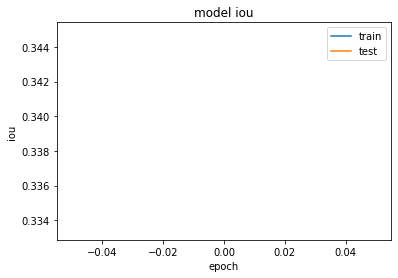

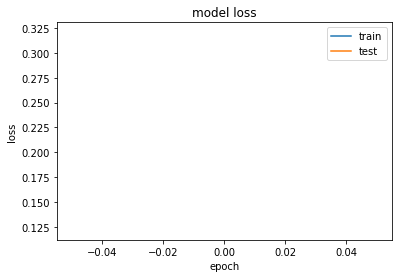

In [ ]:
# Model #1
input_shape = (crop_size, crop_size, 6)
backbone = 'resnet18'
model = ef_model(input_shape, backbone)
model_name = 'model_ef'
model_path = f'saved/models/{dataset}_{backbone}_{model_name}.h5'
history_path = f'saved/histories/{dataset}_{backbone}_{model_name}.pkl'


checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_iou', mode='max', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_iou', mode = 'max', factor=1/np.sqrt(10), patience = rLR_patience, min_lr=1e-6, verbose = 1)
earlystopper = EarlyStopping(monitor='val_iou', mode = 'max', patience = es_patience, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystopper]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
hist = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = callbacks)
with open(history_path, 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

model.load_weights(model_path)
_, test_iou, _ = model.evaluate(test_dataset)
os.rename(model_path, model_path.replace('.h5',f'_{test_iou:.4f}.h5'))
os.rename(history_path, history_path.replace('.pkl',f'_{test_iou:.4f}.pkl'))
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Model 2/3 Data

In [ ]:
# Helper Functions for Model #2 and #3
def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  # image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return imageA, imageB, label

def normalize(imageA, imageB, label):
  imageA = imageA / 255
  imageB = imageB / 255
  label = label / 255
  return imageA, imageB, label

def load_image(image_file):
  imageA, imageB, label = load(image_file)
  imageA, imageB, label = normalize(imageA, imageB, label)
  return (imageA, imageB), label

train_dataset = tf.data.Dataset.list_files(f'{PATH}/train/{pre_image}/*.jpg')
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_length = len(train_dataset)
# train_dataset_length = int(np.ceil(len(os.listdir(f'{PATH}/train/{pre_image}/'))/BATCH_SIZE))

val_dataset = tf.data.Dataset.list_files(f'{PATH}/val/{pre_image}/*.jpg')
val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset_length = len(val_dataset)
# val_dataset_length = int(np.ceil(len(os.listdir(f'{PATH}/train/{pre_image}/'))/BATCH_SIZE))

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)
# test_dataset_length = len(os.listdir(f'{PATH}/train/{pre_image}/'))

print(f'train_dataset_length: {train_dataset_length}, val_dataset_length: {val_dataset_length}, test_dataset_length: {test_dataset_length}')

train_dataset_length: 64, val_dataset_length: 64, test_dataset_length: 64


## Model 2

In [ ]:
# Model 2
def siamconc_model(input_shape = (256, 256, 3), backbone = 'resnet18'):

  ResNet18, preprocess_input = Classifiers.get(backbone)
  encoder = ResNet18(input_shape, weights=None,include_top=False)
  encoder_output = [encoder.output]
  skip_outputs = [encoder.get_layer(f).output for f in ['stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0']]
  skips_model = Model(inputs = encoder.inputs, outputs = encoder_output + skip_outputs)
  inputA = Input((crop_size, crop_size, 3))
  inputB = Input((crop_size, crop_size, 3))
  skipsA = skips_model(inputA)
  skipsB = skips_model(inputB)

  def conv_bn_relu(filters,x):
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

  x = concatenate([skipsA[0], skipsB[0]])
  for i,(skipA, skipB) in enumerate(zip(skipsA[1:], skipsB[1:])):
    x = UpSampling2D(name=f'up{i+1}')(x)
    filters = skipA.shape[-1]
    x = conv_bn_relu(filters,x)
    x = conv_bn_relu(filters,x)
    x = concatenate([x, skipA, skipB])
  x = UpSampling2D(name='up5')(x)
  for filters in [32,32,16,16]:
    x = conv_bn_relu(filters,x)
  x = Conv2D(2, 1, activation = 'softmax', padding='same', kernel_initializer='he_uniform', dtype = 'float32')(x)
  model = Model(inputs = [inputA, inputB], outputs = x)
  return model

In [ ]:
# Model #2
input_shape = (crop_size, crop_size, 3)
backbone = 'resnet18'
model = siamconc_model(input_shape, backbone)
model_name = 'model_siamconc'
model_path = f'saved/models/{dataset}_{backbone}_{model_name}.h5'
history_path = f'saved/histories/{dataset}_{backbone}_{model_name}.pkl'


checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_iou', mode='max', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_iou', mode = 'max', factor=1/np.sqrt(10), patience = rLR_patience, min_lr=1e-6, verbose = 1)
earlystopper = EarlyStopping(monitor='val_iou', mode = 'max', patience = es_patience, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystopper]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
hist = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = callbacks)
with open(history_path, 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

model.load_weights(model_path)
_, test_iou, _ = model.evaluate(test_dataset)
os.rename(model_path, model_path.replace('.h5',f'_{test_iou:.4f}.h5'))
os.rename(history_path, history_path.replace('.pkl',f'_{test_iou:.4f}.pkl'))
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Model 3

In [ ]:
# Model 3
def siamdiff_model(input_shape = (256, 256, 3), backbone = 'resnet18'):

  ResNet18, preprocess_input = Classifiers.get(backbone)
  encoder = ResNet18(input_shape, weights=None,include_top=False)
  encoder_output = [encoder.output]
  skip_outputs = [encoder.get_layer(f).output for f in ['stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0']]
  skips_model = Model(inputs = encoder.inputs, outputs = encoder_output + skip_outputs)
  inputA = Input((crop_size, crop_size, 3))
  inputB = Input((crop_size, crop_size, 3))
  skipsA = skips_model(inputA)
  skipsB = skips_model(inputB)

  def conv_bn_relu(filters,x):
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

  x = concatenate([skipsA[0], skipsB[0]])
  for i,(skipA, skipB) in enumerate(zip(skipsA[1:], skipsB[1:])):
    x = UpSampling2D(name=f'up{i+1}')(x)
    filters = skipA.shape[-1]
    x = conv_bn_relu(filters,x)
    x = conv_bn_relu(filters,x)
    x = concatenate([x, skipA - skipB])
  x = UpSampling2D(name='up5')(x)
  for filters in [32,32,16,16]:
    x = conv_bn_relu(filters,x)
  x = Conv2D(2, 1, activation = 'softmax', padding='same', kernel_initializer='he_uniform', dtype = 'float32')(x)
  model = Model(inputs = [inputA, inputB], outputs = x)
  return model

In [ ]:
# Model #3
input_shape = (crop_size, crop_size, 3)
backbone = 'resnet18'
model = siamdiff_model(input_shape, backbone)
model_name = 'model_siamdiff'
model_path = f'saved/models/{dataset}_{backbone}_{model_name}.h5'
history_path = f'saved/histories/{dataset}_{backbone}_{model_name}.pkl'


checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_iou', mode='max', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_iou', mode = 'max', factor=1/np.sqrt(10), patience = rLR_patience, min_lr=1e-6, verbose = 1)
earlystopper = EarlyStopping(monitor='val_iou', mode = 'max', patience = es_patience, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystopper]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
hist = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = callbacks)
with open(history_path, 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

model.load_weights(model_path)
_, test_iou, _ = model.evaluate(test_dataset)
os.rename(model_path, model_path.replace('.h5',f'_{test_iou:.4f}.h5'))
os.rename(history_path, history_path.replace('.pkl',f'_{test_iou:.4f}.pkl'))
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Move savefile to drive

In [ ]:
!zip -r saved.zip saved/
!cp saved.zip /content/drive/MyDrive/saved.zip

# Add Augmentations

## Canny

In [55]:
# Helper Functions for Model #1

def canny_edge1(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

def canny_edge2(image):
  l,u = 100, 200
  eA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u) / 2.01
  eB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u) / 2.01
  e = eA-eB

  edgesA = e>0
  edgesB = e<0
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges


def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  image = tf.concat([imageA,imageB],axis=-1)
  edges = tf.py_function(canny_edge1, [image], tf.float32)
  image = tf.cast(image,tf.float32)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, edges, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, edges, label = load(image_file)
  image, label = normalize(image, label)
  image = tf.concat([image,edges],axis=-1)
  return image, label

train_dataset = tf.data.Dataset.list_files(f'{PATH}/train/{pre_image}/*.jpg')
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_length = len(train_dataset)
# train_dataset_length = int(np.ceil(len(os.listdir(f'{PATH}/train/{pre_image}/'))/BATCH_SIZE))

val_dataset = tf.data.Dataset.list_files(f'{PATH}/val/{pre_image}/*.jpg')
val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset_length = len(val_dataset)
# val_dataset_length = int(np.ceil(len(os.listdir(f'{PATH}/train/{pre_image}/'))/BATCH_SIZE))

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)
# test_dataset_length = len(os.listdir(f'{PATH}/train/{pre_image}/'))

print(f'train_dataset_length: {train_dataset_length}, val_dataset_length: {val_dataset_length}, test_dataset_length: {test_dataset_length}')

train_dataset_length: 128, val_dataset_length: 32, test_dataset_length: 87


In [ ]:
# # Dataset test
# for x,y in train_dataset.take(1):
#   pass
# idx = 5
# plt.figure(figsize=(20,4))
# plt.subplot(151)
# plt.imshow(x[idx,:,:,:3].numpy())
# plt.subplot(152)
# plt.imshow(x[idx,:,:,6].numpy(),cmap='gray')
# plt.subplot(153)
# plt.imshow(x[idx,:,:,3:6].numpy())
# plt.subplot(154)
# plt.imshow(x[idx,:,:,7].numpy(),cmap='gray')
# plt.subplot(155)
# plt.imshow(y[idx].numpy().argmax(-1),cmap='gray')

In [66]:
# Model #1
def ef_model(input_shape = (256, 256, 8), backbone = 'resnet18'):

  ResNet18, preprocess_input = Classifiers.get(backbone)
  encoder = ResNet18(input_shape, weights=None,include_top=False)
  encoder_output = encoder.output
  skip_outputs = [encoder.get_layer(f).output for f in ['stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0']]

  def conv_bn_relu(filters,x):
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

  x = encoder_output
  for i,skip_output in enumerate(skip_outputs):
    x = UpSampling2D(name=f'up{i+1}')(x)
    filters = skip_output.shape[-1]
    x = conv_bn_relu(filters,x)
    x = conv_bn_relu(filters,x)
    x = concatenate([x, skip_output])
  x = UpSampling2D(name='up5')(x)
  for filters in [32,32,16,16]:
    x = conv_bn_relu(filters,x)
  x = Conv2D(2, 1, activation = 'softmax', padding='same', kernel_initializer='he_uniform', dtype = 'float32')(x)
  model = Model(inputs = encoder.inputs, outputs = x)
  return model

128/128 [==============================] - ETA: 0s - loss: 0.1834 - iou: 0.3087 - accuracy: 0.9286
Epoch 1: val_iou improved from -inf to 0.32974, saving model to saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1.h5
87/87 [==============================] - 24s 271ms/step - loss: nan - iou: 0.3705 - accuracy: 0.9592


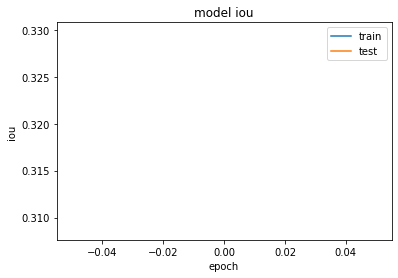

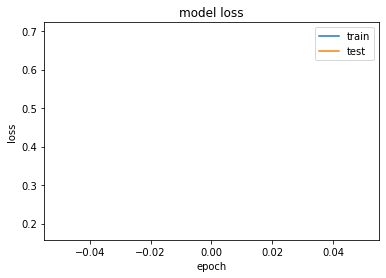

In [67]:
# Model #1
input_shape = (crop_size, crop_size, 8)
backbone = 'resnet18'
model = ef_model(input_shape, backbone)
model_name = 'model_ef'
model_path = f'saved/models/{dataset}_{backbone}_{model_name}_canny1.h5'
history_path = f'saved/histories/{dataset}_{backbone}_{model_name}_canny1.pkl'


checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_iou', mode='max', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_iou', mode = 'max', factor=1/np.sqrt(10), patience = rLR_patience, min_lr=1e-6, verbose = 1)
earlystopper = EarlyStopping(monitor='val_iou', mode = 'max', patience = es_patience, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystopper]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
hist = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = callbacks)
with open(history_path, 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

model.load_weights(model_path)
_, test_iou, _ = model.evaluate(test_dataset)
os.rename(model_path, model_path.replace('.h5',f'_{test_iou:.4f}.h5'))
os.rename(history_path, history_path.replace('.pkl',f'_{test_iou:.4f}.pkl'))
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()